In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import pandas as pd

import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import EuclidOverlapFootprint
from rubin_sim.data import get_baseline


In [2]:
baseline_file = '/Users/yoachim/runs32/noroll/noroll_v3.2_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [3]:
bundle_list = []
nside =128

fpg = EuclidOverlapFootprint(nside=nside)
fp, labels = fpg.return_maps()

in_exgal = np.where((labels == "lowdust"))[0]


bins=np.arange(0,365.25*10, 10)
# col here could be anything
metric = maf.metrics.AccumulateM5Metric(bins=bins)
# Select all the visits. Could do something like 'filter="r"' 
sql = 'filter="r"'
slicer = maf.slicers.HealpixSlicer(nside=nside)
plot_dict = {}
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [4]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
#bg.plot_all(closefigs=False)

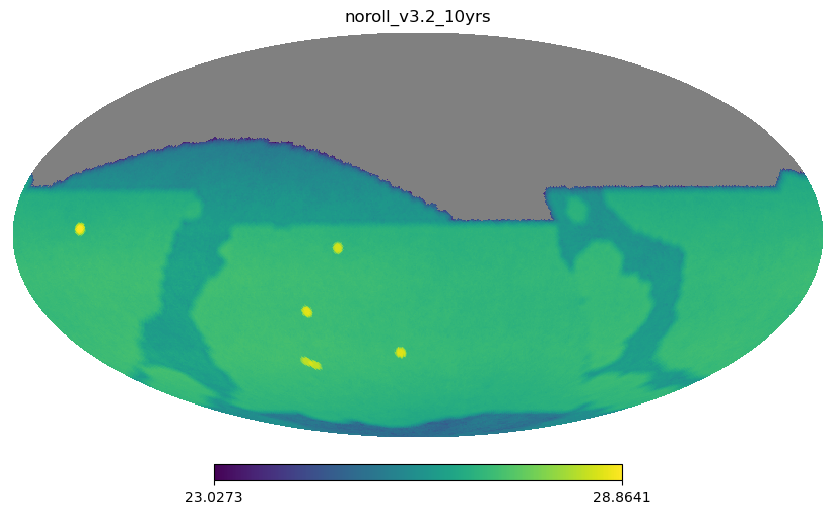

In [5]:
hp.mollview(bundle_list[0].metric_values[:,-1], title=name)

In [6]:
bundle_list[0].metric_values.shape

(196608, 365)

In [7]:
# ok, for each time step we want to know the peak depth, and then the number of pixels around some range of that peak

mag_peaks = []
n_pix = []
bins = np.arange(18,32, 0.025)
x = (bins[0:-1] + bins[:-1])/2.
around = np.array([-1,0,1])
pad = 0.1 # mags

ld = np.where(labels == "lowdust")[0]

for i in np.arange(bundle_list[0].metric_values.shape[-1]):
    slice = bundle_list[0].metric_values[:,i]
    ack, _b = np.histogram(slice[ld], bins=bins)
    peak = np.min(np.where(ack == np.max(ack))[0])
    mag_val = np.average(x[around + peak], weights=ack[around + peak])
    mag_peaks.append(mag_val)
    n_pix_near = np.size(np.where((slice > (mag_val-pad)) & 
                                  (slice < (mag_val+pad)) &
                                   (labels == "lowdust"))[0])
    n_pix.append(n_pix_near)

areas = np.array(n_pix) * hp.nside2pixarea(nside, degrees=True)

Text(0, 0.5, 'coadded depth (mag)')

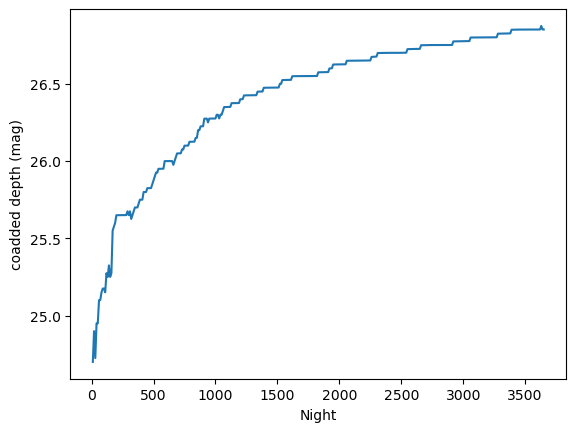

In [8]:
bins = np.arange(0,365.25*10, 10)
plt.plot(bins[1:], mag_peaks)
plt.xlabel('Night')
plt.ylabel('coadded depth (mag)')
           

Text(0, 0.5, 'Area (sq deg)')

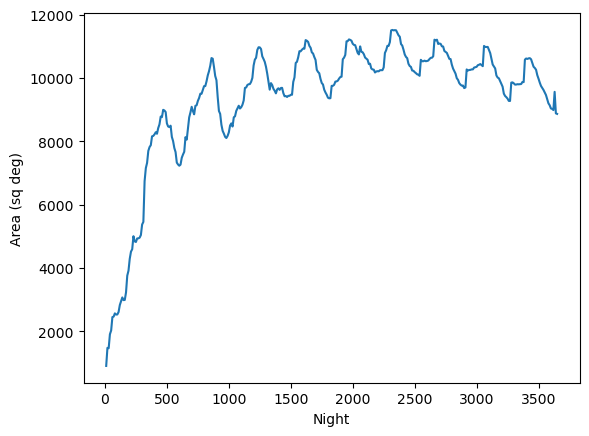

In [9]:
plt.plot(bins[1:], areas)
plt.xlabel('Night')
plt.ylabel('Area (sq deg)')
  

In [10]:
fpg = EuclidOverlapFootprint(nside=nside)
fp, labels = fpg.return_maps()

in_exgal = np.where((labels == "lowdust"))[0]


In [11]:
in_exgal.size*hp.nside2pixarea(nside, degrees=True)

17481.43751269209

In [12]:
years = np.arange(365.25, 365.25*11, 365.25)

mag_int = np.interp(years, bins[1:], mag_peaks)
area_int = np.interp(years, bins[1:], areas)

df = pd.DataFrame()
df['year'] = np.round(years/365.25)
df['mag'] = mag_int
df['Area'] = area_int

df

,year,mag,Area
0,1.0,25.699804,7847.065111
1,2.0,26.074821,9118.558264
2,3.0,26.349914,9056.781006
3,4.0,26.475165,9424.785042
4,5.0,26.565411,9602.463507
5,6.0,26.650074,10204.614732
6,7.0,26.724410,10541.008871
7,8.0,26.774397,10260.574636
8,9.0,26.824528,9856.816691
9,10.0,26.851596,8863.570364
